# Zero Touch 5G Network Security Attack Detection using ML/DL models

In [1]:
# Import all libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.multiclass import OneVsRestClassifier



## Importing Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Temporary dataset
df = pd.read_csv('/content/drive/MyDrive/MMU INTERNSHIP/NIDD_5G_Train_Full.csv')

Mounted at /content/drive


## 1. Data Preprocessing

In [3]:
# Display the details info for each attributes in the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4711553 entries, 0 to 4711552
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   frame.time_relative    float64
 1   ip.src                 object 
 2   ip.dst                 object 
 3   ip.len                 int64  
 4   tcp.flags.syn          float64
 5   tcp.flags.ack          float64
 6   tcp.flags.push         float64
 7   tcp.flags.fin          float64
 8   tcp.flags.reset        float64
 9   tcp.flags.ece          float64
 10  ip.proto               int64  
 11  eth.src                object 
 12  eth.dst                object 
 13  ip.hdr_len             int64  
 14  ip.ttl                 int64  
 15  tcp.window_size_value  int64  
 16  tcp.hdr_len            int64  
 17  udp.length             int64  
 18  srcport                int64  
 19  dstport                int64  
 20  flow.id                object 
 21  label                  object 
dtypes: float64(7), int

In [4]:
# Identify the quantitative columns in the dataset

quantitative_attributes = df.select_dtypes(include=['int64', 'float64'])
print("Quantitative Attributes: ", quantitative_attributes.columns)

Quantitative Attributes:  Index(['frame.time_relative', 'ip.len', 'tcp.flags.syn', 'tcp.flags.ack',
       'tcp.flags.push', 'tcp.flags.fin', 'tcp.flags.reset', 'tcp.flags.ece',
       'ip.proto', 'ip.hdr_len', 'ip.ttl', 'tcp.window_size_value',
       'tcp.hdr_len', 'udp.length', 'srcport', 'dstport'],
      dtype='object')


In [5]:
# Identify the qualitative columns in the dataset

qualitative_attributes = df.select_dtypes(include=['object'])
print("Qualitative Attributes: ", qualitative_attributes.columns)

Qualitative Attributes:  Index(['ip.src', 'ip.dst', 'eth.src', 'eth.dst', 'flow.id', 'label'], dtype='object')


In [6]:
# Drop unnecessary qualtitative columns

columns_to_drop = ['ip.src', 'ip.dst', 'eth.src', 'eth.dst', 'flow.id']
df.drop(columns=columns_to_drop, inplace=True)

In [7]:
# Remove attribute column 'label' from categorical for later encoding

target_col = 'label'
categorical_features = [col for col in qualitative_attributes.columns if col != target_col]

In [8]:
# Check for any missing or inconsistent data values

df.isnull().sum()

,0
frame.time_relative,0
ip.len,0
tcp.flags.syn,3277539
tcp.flags.ack,3277539
tcp.flags.push,3277539
tcp.flags.fin,3277539
tcp.flags.reset,3277539
tcp.flags.ece,3277539
ip.proto,0
ip.hdr_len,0


In [9]:
# Handle missing values in the dataset

# Fill in numerical features' nulls with median
for col in quantitative_attributes.columns:
  df[col] = df[col].fillna(df[col].median())

In [10]:
# Check whether there are still columns with null values or not

df.isnull().sum()

,0
frame.time_relative,0
ip.len,0
tcp.flags.syn,0
tcp.flags.ack,0
tcp.flags.push,0
tcp.flags.fin,0
tcp.flags.reset,0
tcp.flags.ece,0
ip.proto,0
ip.hdr_len,0


In [11]:
# Check if there are any duplicate rows

duplicate_rows = df[df.duplicated()]
print("Number of duplicate rows: ", duplicate_rows.shape)

# Print the duplicate rows
duplicate_rows

Number of duplicate rows:  (986601, 17)


,frame.time_relative,ip.len,tcp.flags.syn,tcp.flags.ack,tcp.flags.push,tcp.flags.fin,tcp.flags.reset,tcp.flags.ece,ip.proto,ip.hdr_len,ip.ttl,tcp.window_size_value,tcp.hdr_len,udp.length,srcport,dstport,label
34,1.815870,1378,0.0,1.0,0.0,0.0,0.0,0.0,17,20,117,0,0,1358,443,48301,Benign
36,1.815940,1378,0.0,1.0,0.0,0.0,0.0,0.0,17,20,117,0,0,1358,443,48301,Benign
37,1.815940,1378,0.0,1.0,0.0,0.0,0.0,0.0,17,20,117,0,0,1358,443,48301,Benign
38,1.815940,1378,0.0,1.0,0.0,0.0,0.0,0.0,17,20,117,0,0,1358,443,48301,Benign
45,1.816047,1378,0.0,1.0,0.0,0.0,0.0,0.0,17,20,117,0,0,1358,443,39210,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4711471,581.711208,1378,0.0,1.0,0.0,0.0,0.0,0.0,17,20,117,0,0,1358,443,41558,Benign
4711472,581.711208,1378,0.0,1.0,0.0,0.0,0.0,0.0,17,20,117,0,0,1358,443,41558,Benign
4711477,581.716842,1378,0.0,1.0,0.0,0.0,0.0,0.0,17,20,117,0,0,1358,443,41558,Benign
4711478,581.716842,1378,0.0,1.0,0.0,0.0,0.0,0.0,17,20,117,0,0,1358,443,41558,Benign


In [12]:
# Remove duplicate rows

df.drop_duplicates(inplace=True)

In [13]:
# Check whether there are still duplicate rows or not
if df.duplicated().any():
    print("There are still duplicate rows in the dataset.")
    duplicate_rows = df[df.duplicated()]
    print("Number of duplicate rows: ", duplicate_rows.shape)
else:
    print("There are no duplicate rows in the dataset.")
duplicate_rows = df[df.duplicated()]

There are no duplicate rows in the dataset.


In [14]:
# One-hot Encoder categorical features (except target)

# Identify remaining categorical features after dropping columns
remaining_categorical_features = df.select_dtypes(include='object').columns.tolist()
if target_col in remaining_categorical_features:
    remaining_categorical_features.remove(target_col)

# Only run if there are any remaining categorical features
if remaining_categorical_features:
  onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
  encoded_categoricals = onehot_encoder.fit_transform(df[remaining_categorical_features])
  encoded_categorical_columns = onehot_encoder.get_features_names_out(remaining_categorical_features)
  encoded_categorical_df = pd.DataFrame(encoded_categoricals, columns=encoded_categorical_columns, index=df.index)
  df = df.drop(columns=remaining_categorical_features)
  df = pd.concat([df, encoded_categorical_df], axis=1)
else:
    print("No categorical features remaining to encode after dropping unnecessary columns.")

No categorical features remaining to encode after dropping unnecessary columns.


In [15]:
# Shape of dataset (rows, cols) after data cleaning
df.shape

(3724952, 17)

### Feature Selections

In [16]:
# Create features and target
X = df.drop(['label'], axis=1)
y = df['label']

In [17]:
df.drop(columns=['tcp.flags.ece', 'ip.hdr_len'], inplace=True)

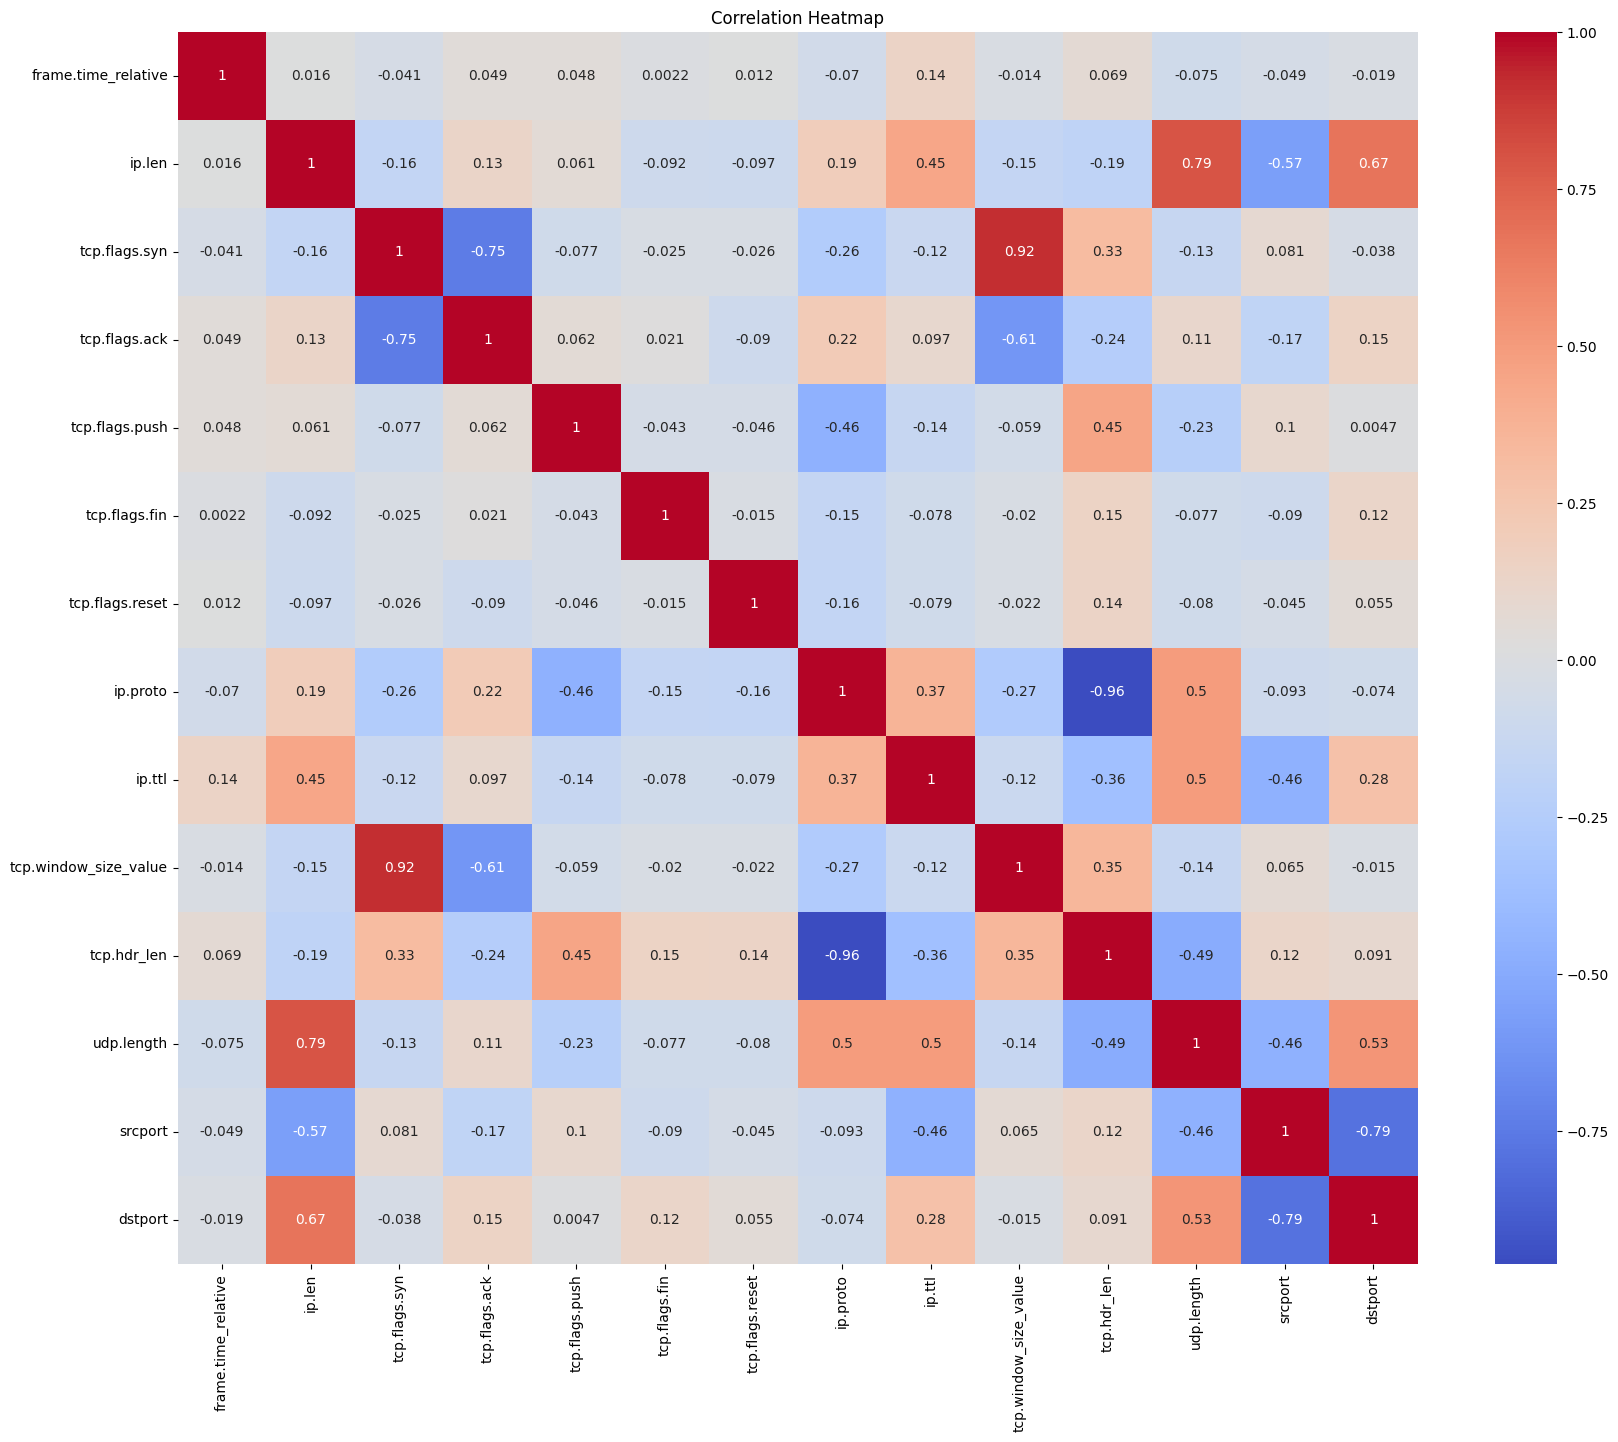

In [18]:
# Check for correlation between features using a heatmap

# Select only numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=np.number)

plt.figure(figsize=(20, 16))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Data Normalization

In [19]:
# Standardize numerical features

scaler = StandardScaler()

# Select only numerical columns that are present in the DataFrame
numerical_columns_present = df.select_dtypes(include=np.number).columns
df[numerical_columns_present] = scaler.fit_transform(df[numerical_columns_present])

In [20]:
label_encoder = LabelEncoder()
df[target_col] = label_encoder.fit_transform(df[target_col])
print("Label classes: ", label_encoder.classes_)

df.value_counts(['label'])

Label classes:  ['Benign' 'HTTPFlood' 'ICMPFlood' 'SYNFlood' 'SYNScan' 'SlowrateDoS'
 'TCPConnectScan' 'UDPFlood' 'UDPScan']


,count
label,
0,2009792
1,637484
7,550471
5,463164
3,19820
6,15297
4,15184
8,12037
2,1703


            Label    Count
0          Benign  2009792
1       HTTPFlood   637484
2       ICMPFlood     1703
3        SYNFlood    19820
4         SYNScan    15184
5     SlowrateDoS   463164
6  TCPConnectScan    15297
7        UDPFlood   550471
8         UDPScan    12037


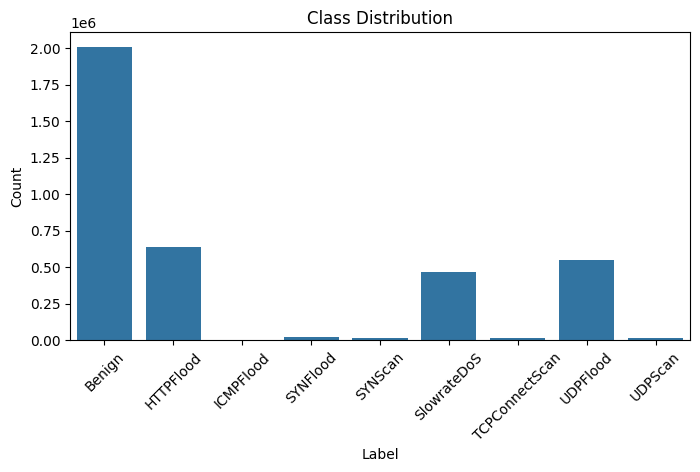

In [21]:
# Class distribution table using Bar Graph

label_counts = df[target_col].value_counts().sort_index()
label_counts_table = pd.DataFrame({'Label': label_encoder.classes_, 'Count': label_counts.values})
print(label_counts_table)

plt.figure(figsize=(8, 4))
sns.barplot(x=label_counts_table['Label'], y=label_counts_table['Count'])
plt.title('Class Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Data Splitting

In [22]:
# Declare feature vector and target variable
X = df.drop(columns=[target_col]).values # Convert to numpy array
y = df[target_col].values # Convert to numpy array

# Split data into train set and test set (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training set shape: ", X_train.shape)
print("Test set shape: ", X_test.shape)

Training set shape:  (2979961, 14)
Test set shape:  (744991, 14)


In [23]:
# One-Hot encoding y for model training (Keras espects One-Hot for softmax)
y_train_oh = pd.get_dummies(y_train)
y_test_oh = pd.get_dummies(y_test)

# Columns aligning
y_test_oh = y_test_oh.reindex(columns=y_train_oh.columns, fill_value=0)

In [24]:
# Reshape input data to 3D

X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# One-hot encode y for model training and testing
y_train_reshaped_oh = pd.get_dummies(y_train)
y_test_reshaped_oh = pd.get_dummies(y_test)
y_test_reshaped_oh = y_test_reshaped_oh.reindex(columns=y_train_reshaped_oh.columns, fill_value=0)

In [25]:
print("Train shape: ", X_train_reshaped.shape, y_train_reshaped_oh.shape)
print("Test shape: ", X_test_reshaped.shape, y_test_reshaped_oh.shape)

Train shape:  (2979961, 1, 14) (2979961, 9)
Test shape:  (744991, 1, 14) (744991, 9)


In [29]:
# Save the train and test sets in an array
np.save('/content/drive/MyDrive/MMU INTERNSHIP/X_train.npy', X_train)
np.save('/content/drive/MyDrive/MMU INTERNSHIP/X_test.npy', X_test)
np.save('/content/drive/MyDrive/MMU INTERNSHIP/X_train_reshaped.npy', X_train_reshaped)
np.save('/content/drive/MyDrive/MMU INTERNSHIP/X_test_reshaped.npy', X_test_reshaped)
np.save('/content/drive/MyDrive/MMU INTERNSHIP/y_train.npy', y_train)
np.save('/content/drive/MyDrive/MMU INTERNSHIP/y_test.npy', y_test)
np.save('/content/drive/MyDrive/MMU INTERNSHIP/y_train_reshaped_oh.npy', y_train_reshaped_oh)
np.save('/content/drive/MyDrive/MMU INTERNSHIP/y_test_reshaped_oh.npy', y_test_reshaped_oh)

In [27]:
# Converting cleaned data into csv file
df.to_csv('/content/drive/MyDrive/MMU INTERNSHIP/NIDD_5G_cleaned.csv', index=False)

## 2.1 Model Building

In [30]:
# Import libraries needed to build the model
!pip install scikeras tensorflow
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import AdditiveAttention, Layer, Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Vanila LSTM

In [31]:
# Define Vanila LSTM Model
inputs = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
x = LSTM(64, return_sequences=False)(inputs)
x = Dropout(0.3)(x)
outputs = Dense(y_train_reshaped_oh.shape[1], activation='softmax')(x)
vanilla_lstm_model = Model(inputs, outputs, name="Vanilla_LSTM")

vanilla_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vanilla_lstm_model.summary()

Model: "Vanilla_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 14)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,809 (81.29 KB)

 Trainable params: 20,809 (81.29 KB)

 Non-trainable params: 0 (0.00 B)

## 2.2 Model Training

### Vanila LSTM

In [32]:
# Add callbacks for better training control

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=5,
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        verbose=1
    )
]

In [34]:
# Fit the training set into the model
vanilla_lstm_model.fit(
    X_train_reshaped, y_train_reshaped_oh,
    epochs=10,
    batch_size=128,
    callbacks=callbacks,
    verbose=1,
    shuffle=True
)

Epoch 1/10
23281/23281 ━━━━━━━━━━━━━━━━━━━━ 133s 6ms/step - accuracy: 0.8625 - loss: 0.2734 - learning_rate: 0.0010
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


23281/23281 ━━━━━━━━━━━━━━━━━━━━ 126s 5ms/step - accuracy: 0.8825 - loss: 0.2151 - learning_rate: 0.0010
Epoch 3/10
23281/23281 ━━━━━━━━━━━━━━━━━━━━ 137s 5ms/step - accuracy: 0.8875 - loss: 0.1980 - learning_rate: 0.0010
Epoch 4/10
23281/23281 ━━━━━━━━━━━━━━━━━━━━ 123s 5ms/step - accuracy: 0.8917 - loss: 0.1848 - learning_rate: 0.0010
Epoch 5/10
23281/23281 ━━━━━━━━━━━━━━━━━━━━ 145s 6ms/step - accuracy: 0.8942 - loss: 0.1764 - learning_rate: 0.0010
Epoch 6/10
23281/23281 ━━━━━━━━━━━━━━━━━━━━ 137s 6ms/step - accuracy: 0.8966 - loss: 0.1695 - learning_rate: 0.0010
Epoch 7/10
23281/23281 ━━━━━━━━━━━━━━━━━━━━ 118s 5ms/step - accuracy: 0.8972 - loss: 0.1659 - learning_rate: 0.0010
Epoch 8/10
23281/23281 ━━━━━━━━━━━━━━━━━━━━ 120s 5ms/step - accuracy: 0.8991 - loss: 0.1617 - learning_rate: 0.0010
Epoch 9/10
23281/23281 ━━━━━━━━━━━━━━━━━━━━ 147s 5ms/step - accuracy: 0.8999 - loss: 0.1593 - learning_rate: 0.0010
Epoch 10/10
23281/23281 ━━━━━━━━━━━━━━━━━━━━ 142s 5ms/step - accuracy: 0.9006 - los

In [35]:
# Evaluate the model using training set

y_train_pred_vanilla_scaled = vanilla_lstm_model.predict(X_train_reshaped)
y_train_pred_vanilla = np.argmax(y_train_pred_vanilla_scaled, axis=1)
model_eval_vanilla = vanilla_lstm_model.evaluate(X_train_reshaped, y_train_reshaped_oh)

93124/93124 ━━━━━━━━━━━━━━━━━━━━ 151s 2ms/step
93124/93124 ━━━━━━━━━━━━━━━━━━━━ 235s 3ms/step - accuracy: 0.9041 - loss: 0.1460


**Confusion Matrix**

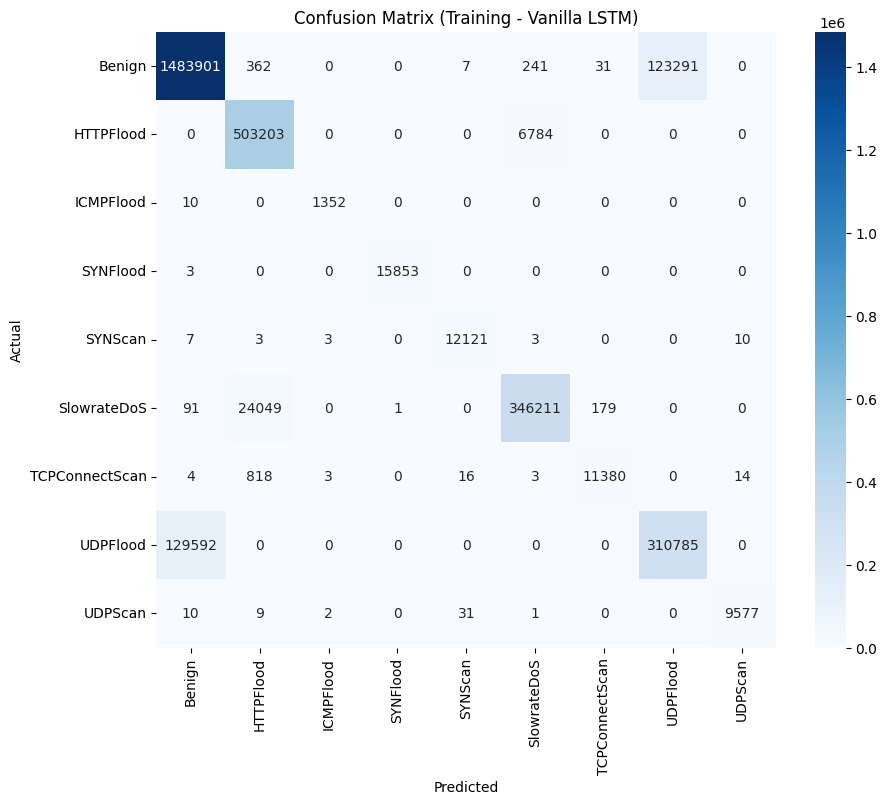

In [36]:
# Display the confusion matrix

# Convert the true labels from the training set from one-hot encoding to class indices
y_train_classes = np.argmax(y_train_reshaped_oh.values, axis=1)

# Use the predicted labels from the training set (already in class indices)
y_train_pred_classes = y_train_pred_vanilla

conf_matrix = confusion_matrix(y_train_classes, y_train_pred_classes)

plt.figure(figsize=(10, 8))
# Use the label_encoder.classes_ for better readability on the heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Training - Vanilla LSTM)')
plt.show()

In [37]:
# Save the true labels from the training set
np.save('/content/drive/MyDrive/MMU INTERNSHIP/y_train_classes.npy', y_train_classes)

**Classification Report**

In [38]:
# Calculate the performance of the model

print('Training report: Vanila LSTM before Hyperparameter Tuning\n')

accuracy_train = accuracy_score(y_train_classes, y_train_pred_classes)
print(f'Accuracy: {accuracy_train * 100:.2f}%')

precision_train = precision_score(y_train_classes, y_train_pred_classes, average='weighted')
print(f'Precision: {precision_train * 100:.2f}%')

recall_train = recall_score(y_train_classes, y_train_pred_classes, average='weighted')
print(f'Recall: {recall_train * 100:.2f}%')

f1_train = f1_score(y_train_classes, y_train_pred_classes, average='weighted')
print(f'F1-score: {f1_train * 100:.2f}%')

# Display the full classification report

print(classification_report(y_train_classes, y_train_pred_classes))



Training report: Vanila LSTM before Hyperparameter Tuning

Accuracy: 90.42%
Precision: 90.39%
Recall: 90.42%
F1-score: 90.39%
              precision    recall  f1-score   support

           0       0.92      0.92      0.92   1607833
           1       0.95      0.99      0.97    509987
           2       0.99      0.99      0.99      1362
           3       1.00      1.00      1.00     15856
           4       1.00      1.00      1.00     12147
           5       0.98      0.93      0.96    370531
           6       0.98      0.93      0.96     12238
           7       0.72      0.71      0.71    440377
           8       1.00      0.99      1.00      9630

    accuracy                           0.90   2979961
   macro avg       0.95      0.94      0.94   2979961
weighted avg       0.90      0.90      0.90   2979961



## 2.3 Hyperparameter Tuning

### Vanila LSTM

In [39]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = []
fold = 0
aucs = 0

# Binarize the true labels for one-vs-rest ROC
y_train_bin = label_binarize(y_train, classes=np.unique(y_train))

for train_idx, val_idx in kf.split(X_train_reshaped):
    X_train_fold = X_train_reshaped[train_idx]
    y_train_fold_oh = y_train_reshaped_oh.values[train_idx]
    X_val_fold = X_train_reshaped[val_idx]
    y_val_fold_oh = y_train_reshaped_oh.values[val_idx]
    y_val_fold_true = y_train_bin[val_idx] # Use binarized true labels for validation

    tuned_vanilla_lstm_model = vanilla_lstm_model
    tuned_vanilla_lstm_model.fit(X_train_fold, y_train_fold_oh, epochs=3, batch_size=128, verbose=1, validation_data=(X_val_fold, y_val_fold_oh)) # Reduced number of epochs

    preds_val = tuned_vanilla_lstm_model.predict(X_val_fold)
    preds.append(preds_val)
    fold += 1

    # Compute ROC for each class in a one-vs-rest approach
    fold_auc = 0
    n_classes = y_val_fold_true.shape[1]
    for i in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y_val_fold_true[:, i], preds_val[:, i])
        fold_auc += auc(fpr, tpr) # Pass the whole fpr and tpr arrays
    fold_auc /= n_classes # Average AUC across classes
    aucs += fold_auc
    print('Fold {}, Average AUC = {}'.format(fold, fold_auc))


print("Cross Validation Average AUC = {}".format(aucs/10))

Epoch 1/3
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 167s 9ms/step - accuracy: 0.9010 - loss: 0.1557 - val_accuracy: 0.9047 - val_loss: 0.1463
Epoch 2/3
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 158s 7ms/step - accuracy: 0.9017 - loss: 0.1543 - val_accuracy: 0.9050 - val_loss: 0.1438
Epoch 3/3
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 117s 6ms/step - accuracy: 0.9023 - loss: 0.1531 - val_accuracy: 0.9046 - val_loss: 0.1440
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step
Fold 1, Average AUC = 0.995003287443388
Epoch 1/3
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 114s 6ms/step - accuracy: 0.9025 - loss: 0.1521 - val_accuracy: 0.9050 - val_loss: 0.1447
Epoch 2/3
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 143s 6ms/step - accuracy: 0.9029 - loss: 0.1511 - val_accuracy: 0.9054 - val_loss: 0.1426
Epoch 3/3
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 148s 6ms/step - accuracy: 0.9034 - loss: 0.1502 - val_accuracy: 0.9059 - val_loss: 0.1427
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step
Fold 2, Average AUC = 0.9950104793567078
Epoch 1/3
18625/18625 ━━━━━━━

**Re-evaluate the Training Set**

93124/93124 ━━━━━━━━━━━━━━━━━━━━ 144s 2ms/step


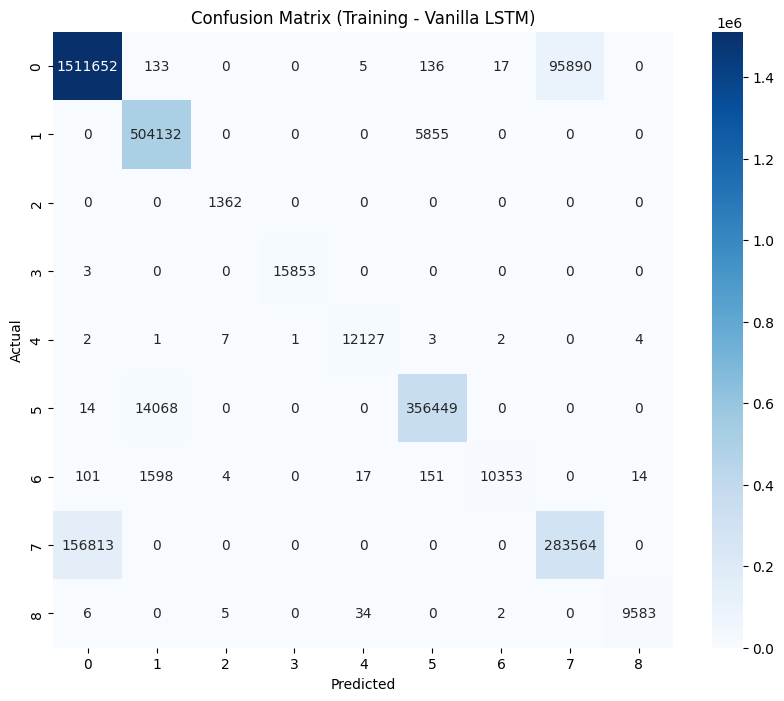

In [40]:
# Using the tuned model
y_train_pred_vanilla_tuned_scaled = tuned_vanilla_lstm_model.predict(X_train_reshaped)
y_train_pred_vanilla_tuned = np.argmax(y_train_pred_vanilla_tuned_scaled, axis=1)

# Display the confusion matrix
conf_matrix = confusion_matrix(y_train_classes, y_train_pred_vanilla_tuned)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Training - Vanilla LSTM)')
plt.show()

In [41]:
# Calculate the performance of the model

print("Training report: Vanila LSTM after Hyperparameter Tuning")

accuracy_train = accuracy_score(y_train_classes, y_train_pred_vanilla_tuned)
print(f'Accuracy: {accuracy_train * 100:.2f}%')

precision_train = precision_score(y_train_classes, y_train_pred_vanilla_tuned, average='weighted')
print(f'Precision: {precision_train * 100:.2f}%')

recall_train = recall_score(y_train_classes, y_train_pred_vanilla_tuned, average='weighted')
print(f'Recall: {recall_train * 100:.2f}%')

f1_train = f1_score(y_train_classes, y_train_pred_vanilla_tuned, average='weighted')
print(f'F1-score: {f1_train * 100:.2f}%')

# Display the full classification report

print(classification_report(y_train_classes, y_train_pred_vanilla_tuned))

Training report: Vanila LSTM after Hyperparameter Tuning
Accuracy: 90.78%
Precision: 90.46%
Recall: 90.78%
F1-score: 90.54%
              precision    recall  f1-score   support

           0       0.91      0.94      0.92   1607833
           1       0.97      0.99      0.98    509987
           2       0.99      1.00      0.99      1362
           3       1.00      1.00      1.00     15856
           4       1.00      1.00      1.00     12147
           5       0.98      0.96      0.97    370531
           6       1.00      0.85      0.92     12238
           7       0.75      0.64      0.69    440377
           8       1.00      1.00      1.00      9630

    accuracy                           0.91   2979961
   macro avg       0.95      0.93      0.94   2979961
weighted avg       0.90      0.91      0.91   2979961



## 2.4 Model Testing

In [42]:
# Predict the target variable for test set using tuned model

y_test_pred_vanilla_tuned_scaled = tuned_vanilla_lstm_model.predict(X_test_reshaped)
y_test_pred_vanilla_tuned = np.argmax(y_test_pred_vanilla_tuned_scaled, axis=1)

23281/23281 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step


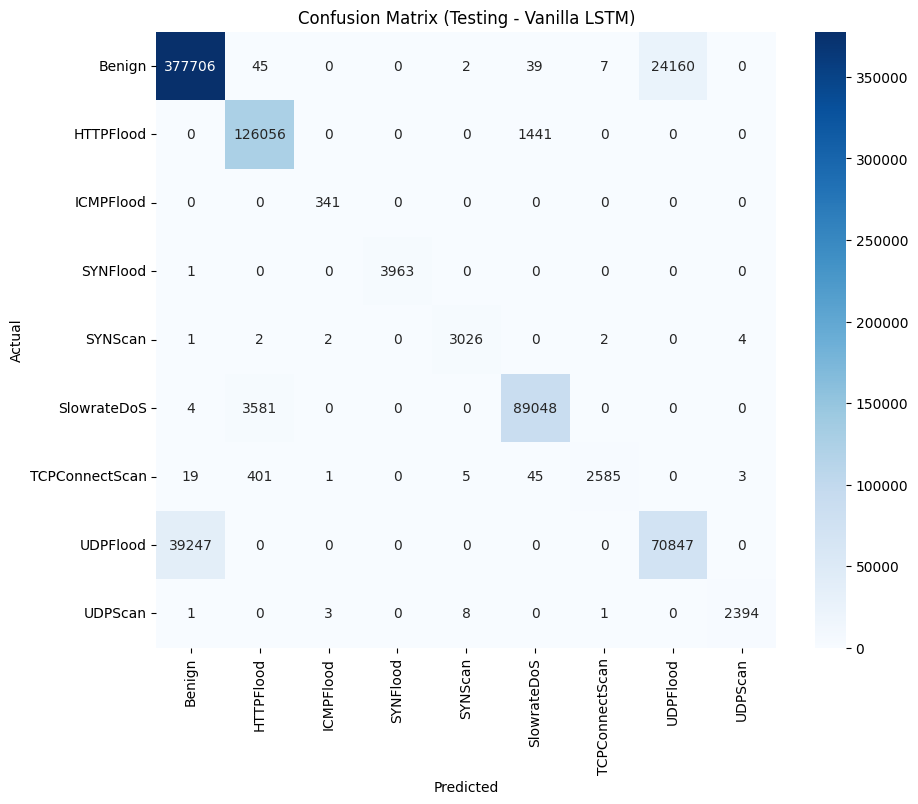

In [43]:
# Display the confusion matrix

# Convert the true labels from the testing set from one-hot encoding to class indices
y_test_classes = np.argmax(y_test_reshaped_oh.values, axis=1)

# Use the predicted labels from the testing set (already in class indices)
y_test_pred_classes = y_test_pred_vanilla_tuned

conf_matrix = confusion_matrix(y_test_classes, y_test_pred_classes)

plt.figure(figsize=(10, 8))
# Use the label_encoder.classes_ for better readability on the heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing - Vanilla LSTM)')
plt.show()

In [44]:
# Calculate the performance of the model

accuracy_test = accuracy_score(y_test_classes, y_test_pred_vanilla_tuned)
print(f'Accuracy: {accuracy_test * 100:.2f}%')

precision_test = precision_score(y_test_classes, y_test_pred_vanilla_tuned, average='weighted')
print(f'Precision: {precision_test * 100:.2f}%')

recall_test = recall_score(y_test_classes, y_test_pred_vanilla_tuned, average='weighted')
print(f'Recall: {recall_test * 100:.2f}%')

f1_test = f1_score(y_test_classes, y_test_pred_vanilla_tuned, average='weighted')
print(f'F1 Score: {f1_train * 100:.2f}%')

# Display the full classification report

print(classification_report(y_test_classes, y_test_pred_vanilla_tuned))

Accuracy: 90.73%
Precision: 90.42%
Recall: 90.73%
F1 Score: 90.54%
              precision    recall  f1-score   support

           0       0.91      0.94      0.92    401959
           1       0.97      0.99      0.98    127497
           2       0.98      1.00      0.99       341
           3       1.00      1.00      1.00      3964
           4       1.00      1.00      1.00      3037
           5       0.98      0.96      0.97     92633
           6       1.00      0.85      0.91      3059
           7       0.75      0.64      0.69    110094
           8       1.00      0.99      1.00      2407

    accuracy                           0.91    744991
   macro avg       0.95      0.93      0.94    744991
weighted avg       0.90      0.91      0.90    744991



In [45]:
# Save the Model using joblib
joblib.dump(tuned_vanilla_lstm_model, '/content/drive/MyDrive/MMU INTERNSHIP/vanilla_lstm_model.pkl')
print("Model saved successfully!")

Model saved successfully!


## 3. One-vs-Rest (OvR) ROC Curves

Epoch 1/3
23281/23281 ━━━━━━━━━━━━━━━━━━━━ 107s 4ms/step - accuracy: 0.8850 - loss: 0.2167
Epoch 2/3
23281/23281 ━━━━━━━━━━━━━━━━━━━━ 106s 5ms/step - accuracy: 0.9067 - loss: 0.1541
Epoch 3/3
23281/23281 ━━━━━━━━━━━━━━━━━━━━ 146s 5ms/step - accuracy: 0.9090 - loss: 0.1440
Epoch 1/3
23281/23281 ━━━━━━━━━━━━━━━━━━━━ 108s 5ms/step - accuracy: 0.9371 - loss: 0.1399
Epoch 2/3
23281/23281 ━━━━━━━━━━━━━━━━━━━━ 138s 4ms/step - accuracy: 0.9743 - loss: 0.0632
Epoch 3/3
23281/23281 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step - accuracy: 0.9791 - loss: 0.0516
Epoch 1/3
23281/23281 ━━━━━━━━━━━━━━━━━━━━ 102s 4ms/step - accuracy: 0.9974 - loss: 0.0193
Epoch 2/3
23281/23281 ━━━━━━━━━━━━━━━━━━━━ 100s 4ms/step - accuracy: 0.9997 - loss: 8.3540e-04
Epoch 3/3
23281/23281 ━━━━━━━━━━━━━━━━━━━━ 144s 4ms/step - accuracy: 0.9999 - loss: 2.2414e-04
Epoch 1/3
23281/23281 ━━━━━━━━━━━━━━━━━━━━ 106s 4ms/step - accuracy: 0.9973 - loss: 0.0183
Epoch 2/3
23281/23281 ━━━━━━━━━━━━━━━━━━━━ 102s 4ms/step - accuracy: 1.0000 - loss

/tmp/ipython-input-1576694981.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


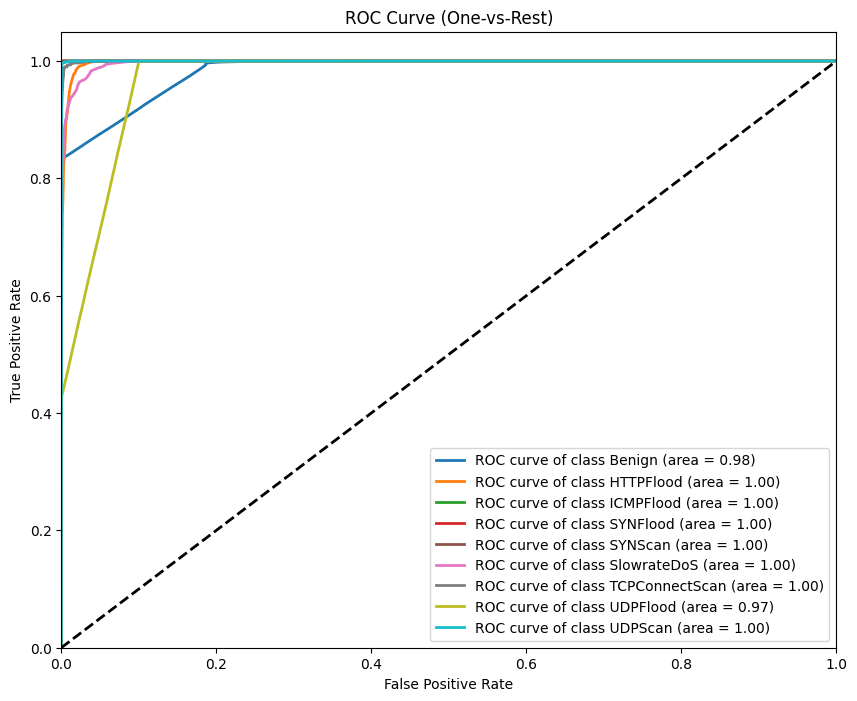

In [ ]:
# Assuming y_test_reshaped_oh is the one-hot encoded test labels
y_test_bin = y_test_reshaped_oh.values
n_classes = y_test_bin.shape[1]

# Wrap the Keras model with KerasClassifier
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.losses import BinaryCrossentropy


# Define a function that returns the Keras model
def build_vanilla_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=False)(inputs)
    x = Dropout(0.3)(x)
    # Use sigmoid activation for binary classification in OneVsRestClassifier
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs, name="Vanilla_LSTM")
    # Use binary_crossentropy for binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create a KerasClassifier from the model-building function
keras_model = KerasClassifier(model=build_vanilla_lstm_model,
                              input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]),
                              num_classes=y_train_reshaped_oh.shape[1], # Still need this for KerasClassifier
                              epochs=3, # Reduced epochs for faster execution during cross-validation
                              batch_size=128,
                              verbose=1) # Set verbose to 1 to see training progress


# Fit in the OvR model
classifier = OneVsRestClassifier(keras_model)
# Use the original y_train for fitting the OneVsRestClassifier
classifier.fit(X_train_reshaped, y_train)


# Predict the probabilities
y_score = classifier.predict_proba(X_test_reshaped)


# Compute ROC curve and AUC for each class

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', n_classes)
for i, color in zip(range(n_classes), colors.colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

5821/5821 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step
5821/5821 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
5821/5821 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
5821/5821 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
5821/5821 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
5821/5821 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
5821/5821 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
5821/5821 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
5821/5821 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


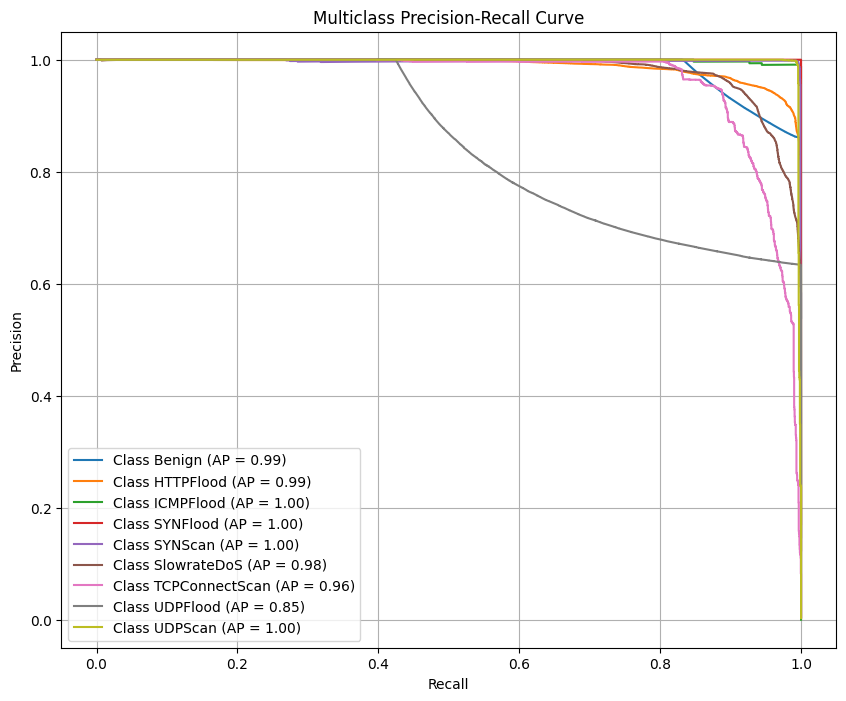

In [ ]:
# Assuming y_test_reshaped_oh is the one-hot encoded test labels
y_test_bin = y_test_reshaped_oh.values
n_classes = y_test_bin.shape[1]

# Predict probabilities
y_score = classifier.predict_proba(X_test_reshaped)

# Plot precision-recall for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
  precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
  avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
  plt.plot(recall, precision, label=f'Class {label_encoder.classes_[i]} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()